<a id='section_id0'></a>
# Data Programming Essentials *with Python*

## Part 4-Modeling 3 : KNN

<font color="#740202">**Table of contents:**

|No.|Topic||No.|Topic||No.|Topic|
|:------|:------||:------|:------||:------|:------|
|1.|[Key Libraries](#section_id1)||2.|[Regression-Sleeping dataset](#section_id3)  |
|3.|[Classification method](#section_id4)  ||4.|[Mapping Neighbors](#section_id5)  ||5.|[References](#section_id6)  |

***

<a id='section_id1'></a>
### <span style="background-color:#B0E0E6">Key libraries</span>
* We'll use the [Nearest Neighbors](https://scikit-learn.org/stable/modules/neighbors.html) module of scikit-learn
* [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) implements classification using a simple majority vote of the nearest neighbors
* [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) assigns values based on the mean of the values of the nearest neighbors to a data point.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# for KNN:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

#for model evaluation and pre-processing tools:
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report, precision_score, \
                            accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score

#for plotting confusion matrix:
import scikitplot as skplt

#utility tools of the DMBA book. 
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import classificationSummary, gainsChart, liftChart

# visualization and tuning the aesthetics
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex = False)
plt.rc('font', family = 'serif')
plt.rc('xtick', labelsize = 10) 
plt.rc('ytick', labelsize = 10) 
plt.rc('font', size = 12) 
plt.rc('figure', figsize = (6, 5))

no display found. Using non-interactive Agg backend


<div style="text-align: right"> <a href='#section_id0'>Back to top of Notebook</a></div>

<a id='section_id3'></a>
### <span style="background-color:#B0E0E6">Regression-sleeping dataset</span>

|Variable|Description|
|:------|:------|
|sleeping|sleep hours on an average shcool night: 1=<4 hrs, 2=5 hrs, 3=6 hrs, 4=7 hrs, 5=8 hrs, 6=9 hrs, 7= >=10 hrs|
|sex|1=Female, 2=Male|
|race|1=White, 2=Black or African American, 3=Hispanic/Latino, 4=All other races|
|sexharass|sexual harassment during the past 12 months: 1=0 times, 2=1 time, 3=2 or 3 times, 4=4 or 5 times, 5=6 or more times|
|smoking|smoke cigarettes during the past 30 days: 1=0 days, 2=1 or 2 days, 3=3 to 5 days, 4= 6 to 9 days, 5=10 to 19 days, 6=20 to 29 days, 7=all 30 days|
|vegetables|eating other vegetables(do not count green salad, potatoes, or carrots) during the past 7 days: 1=0 times, 2=1 to 3 times, 3=4 to 6 times, 4=1 time/day, 5=2 times/day, 6=3 times/day, 7=>= 4 times/day|
|soda|drinking soda or pop during past 7 days: 1= 0 times, 2=1 to 3 times, 3=4 to 6 times, 4=1 time/day, 5=2 times/day, 6=3 times/day, 7=>=4 times/day |
|breakfast|days of eating breakfast per week: 1=0 day, 2=1 day, 3=2 days, 4=3 days, 5= 4 days, 6=5 days, 7=6 days, 8= 7 days|
|computer|hours of playing computer games or something that is not school work per day: 1=0 hrs, 2=<1 hr, 3=1 hr, 4=2 hrs, 5=3 hrs, 6=4 hrs, 7=>=5 hrs|

In [2]:
df1 = pd.read_csv('sleeping.csv')

In [3]:
df1.head(3)

,sleeping,sex,race,sexharass,smoking,vegetables,soda,breakfast,computer
0,1,2,4,4,4,3,2,3,3
1,1,2,3,1,1,2,1,1,2
2,1,2,4,1,1,1,1,1,1


In [4]:
# First, scale the predictors and predicted variables:
Xp=preprocessing.scale(df1[['sex', 'race', 'sexharass', 'smoking', 'vegetables', 'soda', 'breakfast',
                            'computer']]).astype('float64')
Yp=preprocessing.scale(df1.sleeping).astype('float64')#scaling

In [5]:
# Set aside a portion (e.g., 25%) of data for out-of-training-sample testing.

X3p_train, X3p_test, Y3p_train, Y3p_test = train_test_split(Xp, Yp, \
                                                            test_size=0.25, random_state=7)
print(X3p_train.shape, Y3p_train.shape)
print(X3p_test.shape, Y3p_test.shape)

(27165, 8) (27165,)
(9055, 8) (9055,)


In [6]:
# Define the KNN model parameters
knn_rcv = KNeighborsRegressor(n_neighbors=4, weights='uniform') 
# use 4 nearest neighbors weighted uniformly

More parameters to tweak are available in [the module](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html), and we can use it to fine tune the models later.

In [7]:
# fit the KNN model using training sample
knn_rcv.fit(X3p_train, Y3p_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                    weights='uniform')

In [8]:
# how does the model perform in training?
knn_prediction_reg=knn_rcv.predict(X3p_train) 
#get the predictions using training data

In [9]:
np.sqrt(np.square(Y3p_train-knn_prediction_reg).mean()) 
#average error of prediction in training data.

0.8892321867404388

In [10]:
import statsmodels.api as sm
sm.tools.eval_measures.rmse(Y3p_train, knn_prediction_reg, axis=0)

0.8892321867404388

In [11]:
# We can also use this handy function from the DMBA package to print all the metrics in one go.
regressionSummary(Y3p_train, knn_prediction_reg)


Regression statistics

                      Mean Error (ME) : -0.0037
       Root Mean Squared Error (RMSE) : 0.8892
            Mean Absolute Error (MAE) : 0.7026
          Mean Percentage Error (MPE) : 71.6318
Mean Absolute Percentage Error (MAPE) : 98.3992


<Mark>Note:</Mark> After scaling, the units of the variables are not aligned with the original measurements. We see that the KNN regression produces an RMSE of about 0.89 units of scaled sleeping hours. To interpret the results in the original units of satisfaction degree, we need to rescale the predictions.

In [12]:
df1.sleeping.describe()

count    36220.000000
mean         3.508007
std          1.398969
min          1.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          7.000000
Name: sleeping, dtype: float64

In [13]:
#to rescale the predicted values, we need to first fit the original scaler:
data = df1.sleeping.values
scaler = preprocessing.StandardScaler()
scaler.fit(data.reshape(-1, 1)) #reshaping is needed for 1-dimensional arrays
scaled = scaler.transform(data.reshape(-1, 1))
# for inverse transformation
inversedpredictions = scaler.inverse_transform(knn_prediction_reg)

In [14]:
regressionSummary(Y3p_train,inversedpredictions)


Regression statistics

                      Mean Error (ME) : -3.5129
       Root Mean Squared Error (RMSE) : 3.6372
            Mean Absolute Error (MAE) : 3.5136
          Mean Percentage Error (MPE) : 4.2692
Mean Absolute Percentage Error (MAPE) : 641.8231


<Mark>Interpretation:</Mark> We see that, on average, the KNN predictor's error is about 0.89 scaled sleeping hours or 3.64 hours of sleeping duration.


In [15]:
# how does the model perform when there is variation on different training samples?
cvparam = KFold(3, random_state=13)
scores_mse_knn =  cross_validate(knn_rcv, X3p_train, Y3p_train, \
                                 cv=cvparam, scoring='neg_mean_squared_error') #10-fold

C:\Users\edwar\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [16]:
# how does the model perform when there is variation on different training samples?
scores_mse_knn['test_score']

array([-1.09657337, -1.12143064, -1.11879255])

In [17]:
np.sqrt(scores_mse_knn['test_score'].mean()*-1) #Multiplying by -1 to remove negativity in MSE

1.0546399955183645

<Mark>Interpretation:</Mark> We see that the KNN model's prediction after 3-fold cross validation is yeilding a prediction with 1.05 scaled units of sleeping hours, an obvious increase in RMSE.

In [21]:
# How does the trained model do for the testing sample?
knn_prediction_reg_tt=knn_rcv.predict(X3p_test) #get the predictions using test data

In [22]:
#average error of prediction in training data.
np.sqrt(np.square(knn_prediction_reg_tt-Y3p_test).mean())

1.0540389952411005

In [23]:
regressionSummary(Y3p_test,knn_prediction_reg_tt)


Regression statistics

                      Mean Error (ME) : 0.0035
       Root Mean Squared Error (RMSE) : 1.0540
            Mean Absolute Error (MAE) : 0.8370
          Mean Percentage Error (MPE) : 87.4009
Mean Absolute Percentage Error (MAPE) : 116.1070


In [24]:
#to rescale the predicted values, we need to first fit the original scaler:
data = df1.sleeping.values
scaler = preprocessing.StandardScaler()
scaler.fit(data.reshape(-1, 1)) #reshaping is needed for 1-dimensional arrays
scaled = scaler.transform(data.reshape(-1, 1))
# for inverse transformation
inversedpredictions = scaler.inverse_transform(knn_prediction_reg_tt)

In [25]:
regressionSummary(Y3p_test,inversedpredictions)


Regression statistics

                      Mean Error (ME) : -3.5036
       Root Mean Squared Error (RMSE) : 3.6909
            Mean Absolute Error (MAE) : 3.5066
          Mean Percentage Error (MPE) : 16.7408
Mean Absolute Percentage Error (MAPE) : 642.2926


</Mark> We see that the KNN model's prediction on testing sample is pretty similar with training data: the test error is about 1.05 scaled sleeping hours or 3.69 hours of sleeping duration.

<div style="text-align: right"> <a href='#section_id0'>Back to top of Notebook</a></div>

<a id='section_id4'></a>
### <span style="background-color:#B0E0E6">Classification method</span>


In [26]:
# inserting a health_category column
df1['sleepcat']=pd.cut(df1['sleeping'], bins=[0,4,8], labels=['short', 'long']) # 0 = short, 1 =long
df1.head(6)

,sleeping,sex,race,sexharass,smoking,vegetables,soda,breakfast,computer,sleepcat
0,1,2,4,4,4,3,2,3,3,short
1,1,2,3,1,1,2,1,1,2,short
2,1,2,4,1,1,1,1,1,1,short
3,3,2,4,1,1,3,5,5,4,short
4,3,2,4,1,6,2,6,5,7,short
5,5,2,4,1,1,5,2,4,5,long


In [27]:
# pre-processing the data to get dummy for dependent variable
healthdummy=pd.get_dummies(df1['sleepcat'])
 #one dummy variable is sufficient for predictor with 2-levels
df1['sleeplong']=healthdummy['long']

In [28]:
yvar= df1.sleeplong.astype('float64')
 #just retain the independent variables
Xvar = df1.drop(['sleeping', 'sleeplong', 'sleepcat'], axis=1).astype('float64')

In [29]:
Xvar.head(3)

,sex,race,sexharass,smoking,vegetables,soda,breakfast,computer
0,2.0,4.0,4.0,4.0,3.0,2.0,3.0,3.0
1,2.0,3.0,1.0,1.0,2.0,1.0,1.0,2.0
2,2.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0


In [30]:
# we scale the Xvar before using KNN:
Xvarpc=preprocessing.scale(Xvar)

The response variable yvar doesn't need scaling becuase it is a binary variable.

In [31]:
# Set aside 25% of data for out-of-training-sample test:
X3pc_train, X3pc_test, Y3pc_train, Y3pc_test = train_test_split(Xvarpc, yvar, \
                                                           test_size=0.25, random_state=7)
print(X3pc_train.shape, Y3pc_train.shape)
print(X3pc_test.shape, Y3pc_test.shape)

(27165, 8) (27165,)
(9055, 8) (9055,)


In [32]:
# Specify the parameters of the KNN classifer:
knn_ccv = KNeighborsClassifier(n_neighbors=4, weights='uniform') # considering 4 nearest neighbors weighted equally

In [33]:
# Fit the KNN model with training data:
knn_ccv.fit(X3pc_train, Y3pc_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [34]:
# Get the prediction of the KNN training
knn_prediction_ctr=knn_ccv.predict(X3pc_train)

In [35]:
# Evaluate how good the knn classification of training data is:
cm_knn = confusion_matrix(Y3pc_train, knn_prediction_ctr)
print("Confusion Matrix:\n", cm_knn)
print("\n")
print("Classification Report:\n",classification_report(Y3pc_train, knn_prediction_ctr))

Confusion Matrix:
 [[19654   743]
 [ 5639  1129]]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.96      0.86     20397
         1.0       0.60      0.17      0.26      6768

    accuracy                           0.77     27165
   macro avg       0.69      0.57      0.56     27165
weighted avg       0.73      0.77      0.71     27165



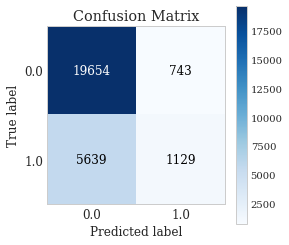

In [36]:
skplt.metrics.plot_confusion_matrix(Y3pc_train, knn_prediction_ctr, figsize=(4,4), cmap="Blues")

<Mark>Interpretation:</Mark> We see that the model resulted in 77% accuracy of classifying sleep duration. 1129 people who were sleep sufficiently were correctly identified by the model.It missed 5639 people and wrongly predicted 743 others having sufficient sleep.<br>

In [37]:
# Evaluate how good the knn classification, after cross-validation:
cvparam = KFold(3, random_state=13)
scores_accuracy_knn =  cross_val_score(knn_ccv, X3pc_train, Y3pc_train, cv=cvparam, scoring='accuracy')

C:\Users\edwar\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


<Mark>Note:</Mark> The features of the [cross_validate() function](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-and-model-selection) are quite extensive. Several ways of splitting the data are possible. 
* Here, we are just doing a basic K-fold split (k=3 in our example).
* The MSE score in each of the three folds is stored in the "scores_accuracy_knn" array.
* The scoring algorithm returns the accuracy metric derived from the confusion matrix of each of the 3 folds

In [38]:
scores_accuracy_knn.mean() #average training accuracy

0.7298361862690963

<Mark>Interpretation:</Mark> We see that the model, after 10-fold cross validation, resulted in 73% accuracy of classifying students on their sleep duration. <br>

In [39]:
# How good is the trained model for predicting the test data?
knn_prediction_ctr_tt=knn_ccv.predict(X3pc_test) #use test data

In [40]:
# Evaluate how good the knn classification of training data is:
cm_knn_tt = confusion_matrix(Y3pc_test, knn_prediction_ctr_tt)
print("Confusion Matrix:\n", cm_knn_tt)
print("\n")
print("Classification Report:\n",classification_report(Y3pc_test, knn_prediction_ctr_tt))

Confusion Matrix:
 [[6405  430]
 [2012  208]]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.94      0.84      6835
         1.0       0.33      0.09      0.15      2220

    accuracy                           0.73      9055
   macro avg       0.54      0.52      0.49      9055
weighted avg       0.65      0.73      0.67      9055



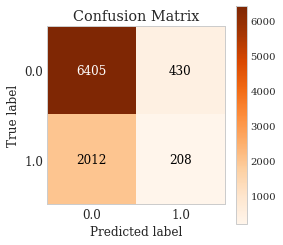

In [41]:
skplt.metrics.plot_confusion_matrix(Y3pc_test, knn_prediction_ctr_tt, figsize=(4,4), cmap="Oranges")

<Mark>Interpretation:</Mark> We see that the model resulted in 73% accuracy of classifying people on their satisfaction degree, 208 students who have sufficient sleep were correctly identified by the model.It missed 2012 people and wrongly predicted 430 others as having sufficient sleep.<br>

Is the model's accuracy better than a naive prediction? A naive prediction is to say that "no body is satisfied".

In [42]:
1-df1.sleeplong.mean()

0.7518498067366096

In [43]:
df1.sleeplong.describe()

count    36220.000000
mean         0.248150
std          0.431945
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: sleeplong, dtype: float64

In [44]:
df1[df1['sleeplong']==1].shape[0]

8988

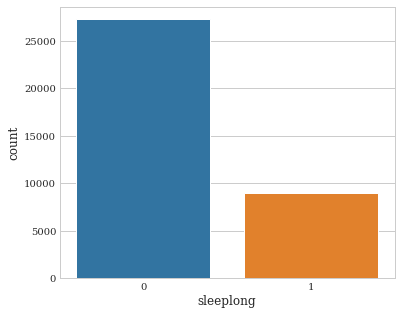

In [45]:
# Exploring why our naive prediction is about the same as the logistic regression
sns.countplot(x="sleeplong", data=df1)

<Mark>Interpretation:</Mark> Clearly, more students have insufficient sleep. The naive prediction accuracy is a little higher than KNN models discussed above.

<div style="text-align: right"> <a href='#section_id0'>Back to top of Notebook</a></div>

<a id='section_id5'></a>
### <span style="background-color:#B0E0E6">Mapping Neighbors</span>
* Identifying the nearest neighbors can be managerially relevant.
* This is an example of unsupervised learning

In [47]:
#define and fit the function using training data
nbrs = NearestNeighbors(n_neighbors=4, algorithm='auto').fit(X3pc_train)

* The choice of neighbors search algorithm is controlled through the keyword 'algorithm', which must be one of 'auto', 'ball_tree', 'kd_tree', 'brute'. 
* When the default value 'auto' is passed, the algorithm attempts to determine the best approach from the training data. 
* For a discussion of the strengths and weaknesses of each option, see [Nearest Neighbor Algorithms](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbor-algorithms)

In [48]:
#find the neighbors on test set
distances, indices = nbrs.kneighbors(X3pc_test)

In [49]:
#map the results for convenient reference
nnindex=pd.DataFrame(indices, columns=['n1', 'n2', 'n3','n4'])
nndistance=pd.DataFrame(distances, columns=['d1', 'd2', 'd3','d4'])
neighbors_map=pd.concat([nnindex, nndistance], axis=1, sort=False)
neighbors_map.head()

,n1,n2,n3,n4,d1,d2,d3,d4
0,17021,25581,20415,8243,0.000000,0.734930,0.752709,0.825690
1,5576,1478,11087,11481,0.000000,0.000000,0.000000,0.000000
2,12772,24775,8774,3030,0.591473,0.815165,1.055710,1.055710
3,14811,2550,835,2934,0.897851,1.051994,1.063859,1.063859
4,23083,3691,181,4523,0.000000,0.000000,0.376355,0.456286


<a id='section_id6'></a>
### <span style="background-color:#B0E0E6">References:</span>

* Chapter 7 of _Datamining for Business Analytics_. [Access through Pitt library](https://pitt.summon.serialssolutions.com/#!/search?bookMark=ePnHCXMw42JgAfZbU5khpymBDxSztADNrHEZgbYtA2tc0K0CXMBq3gRYkwA7SJwMSi6JJYkKueALERSATTUF6P2LxQqJoIM5QMcV8zCwpgGjI5WXgaWkqBRYcEq7uYY4e-iCDkeKhw50xAPTkpmJBejiIfyyKlhkYXM9QGVA95qYGQMA-383uA)
* Another book I like is: [Introduction to Statistical Learning](http://faculty.marshall.usc.edu/gareth-james/ISL/). The ISL book provides intuitive and "math-lite" explanations for many concepts. 
    * The ISL book uses "R for lab exercises," but the concepts covered are independent of the programming language.
    * [The videos](https://www.dataschool.io/15-hours-of-expert-machine-learning-videos/) from the authors of the ISL book are a great resource.
    * Another book, [Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn/), has more advanced treatment of the topics covered by ISL.

***

<font color="#610B21"><center>\~\~ End of Part-4. We'll discuss Naive Bayes in Part-5\~\~ </center>

***